# Biomarker Identification

In [12]:
# adding the project root inside the python path
import sys
import os
import typing as tp

sys.path.insert(0, os.path.abspath('..'))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from bioinfokit import visuz
from analysis.preprocess import PreprocessPipeline

In [3]:
pipeline = PreprocessPipeline(
    datasets_path='../../dataset/first_disease_sel',
    disease_col_name='DISEASE',
    output_dir='/tmp/chl/',
)

pipeline.execute_pipeline()
df = pipeline.dataset

INFO:root:Starting pipeline
INFO:root:Loading datasets
INFO:root:Inspecting directory ../../dataset/first_disease_sel/NALD
INFO:root:Setting disease as NALD
INFO:root:Loading file ../../dataset/first_disease_sel/NALD/eGSE117647m.csv
INFO:root:Loading file ../../dataset/first_disease_sel/NALD/eGSE34308m.csv
INFO:root:Loading file ../../dataset/first_disease_sel/NALD/eGSE85804m.csv
INFO:root:Inspecting directory ../../dataset/first_disease_sel/GS
INFO:root:Setting disease as GS
INFO:root:Loading file ../../dataset/first_disease_sel/GS/eGSE117146m.csv
INFO:root:Inspecting directory ../../dataset/first_disease_sel/MCM
INFO:root:Setting disease as MCM
INFO:root:Loading file ../../dataset/first_disease_sel/MCM/MCM_GSE149607.csv
INFO:root:Inspecting directory ../../dataset/first_disease_sel/DIABETE
INFO:root:Setting disease as DIABETE
INFO:root:Loading file ../../dataset/first_disease_sel/DIABETE/eGSE27949m.csv
INFO:root:Loading file ../../dataset/first_disease_sel/DIABETE/eGSE25462m.csv
INFO

In [4]:
pipeline.train_set['DISEASE'].value_counts()

DIABETE    132
A1A         96
NALD        28
GS          22
MCM         21
Name: DISEASE, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 399 entries, NALD_1 to A1A_127
Columns: 4602 entries, SNW1 to VPS13B
dtypes: float64(4601), object(1)
memory usage: 14.0+ MB


In [6]:
df.head()

,SNW1,PLK2,BNIP2,TPD52L2,PQBP1,MSN,UBC,TECPR2,HTRA1,TSC2,...,DCTN5,MAP4K4,ACOT8,DDX41,NCKIPSD,TXNDC16,NUP37,DBNDD1,S100A13,VPS13B
NALD_1,0.440238,0.293343,0.269409,0.244278,0.098134,0.419520,0.207598,0.306280,0.000000,0.424847,...,0.324849,0.559540,0.098198,0.416292,0.263628,0.320890,0.000000,0.578780,0.288886,0.336852
NALD_2,0.852364,0.237909,0.108162,0.080024,0.090142,0.373833,0.045947,0.575790,0.066061,0.551240,...,0.649927,0.731003,0.896780,0.536746,0.491360,0.472457,0.374097,0.575309,0.000000,0.465035
NALD_3,0.323746,0.342898,0.599963,0.100134,0.091576,0.480269,0.302024,0.508384,0.115080,0.139543,...,0.538277,0.912390,0.603379,0.559015,0.853488,0.244969,0.591380,0.951371,0.374492,0.402094
NALD_4,0.909502,0.456057,0.739749,0.626319,0.000000,0.697761,0.505117,0.317133,0.049717,0.821632,...,0.538653,0.826254,0.487701,0.758664,0.971363,0.335907,1.000000,0.562447,1.000000,0.546483
NALD_5,0.000000,0.000000,1.000000,0.261953,0.045957,0.350236,0.164907,1.000000,0.086153,0.000000,...,1.000000,0.942497,0.498598,0.576729,0.554648,0.094399,0.901733,0.891699,0.162327,0.065127


## Inspecting dataset we have built

DIABETE    176
A1A        128
NALD        38
GS          29
MCM         28
Name: DISEASE, dtype: int64


<AxesSubplot:>

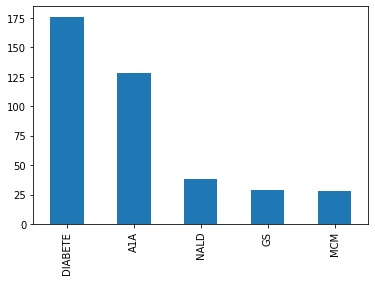

In [7]:
# plotting the number of sample for each disease
disease = df['DISEASE'].value_counts()
print(disease)
disease.plot.bar()

## Genes' visualization

In [8]:
data_cols = [col_name for col_name in df.columns if col_name != 'DISEASE']

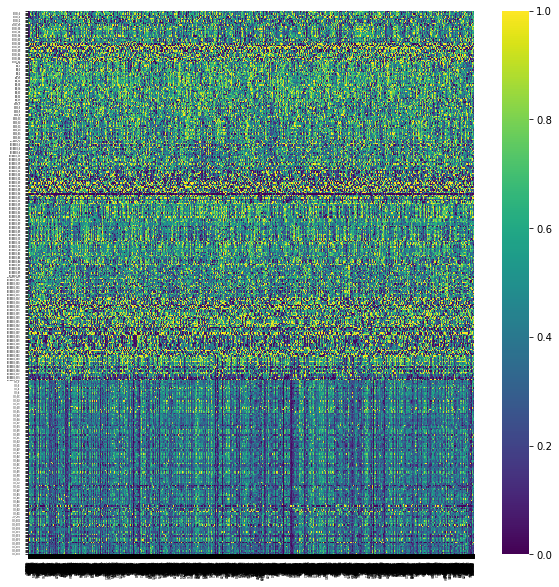

In [9]:
visuz.gene_exp.hmap(df=df[data_cols], cmap='viridis', rowclus=False, colclus=False, dim=(10, 10), tickfont=(3, 2), show=True)

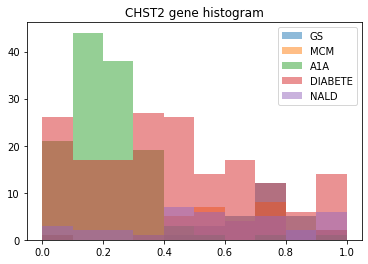

In [10]:
gene = 'CHST2'
plt.hist(df.loc[df['DISEASE']=='GS', gene], bins=10, alpha=0.5)
plt.hist(df.loc[df['DISEASE']=='MCM', gene], bins=10, alpha=0.5)
plt.hist(df.loc[df['DISEASE']=='A1A', gene], bins=10, alpha=0.5)
plt.hist(df.loc[df['DISEASE']=='DIABETE', gene], bins=10, alpha=0.5)
plt.hist(df.loc[df['DISEASE']=='NALD', gene], bins=10, alpha=0.5)

plt.title(gene+' gene histogram')  
plt.legend(['GS', 'MCM', 'A1A', 'DIABETE', 'NALD'])
  
plt.show()

## Biomarker Identification pipeline

1. Pairwise statistical test
2. Gene selection for each pair of disease
3. Gene intersection/union

In [13]:
from collections.abc import Callable
import itertools
def pairwise_hyp_testing(df: pd.DataFrame, disease_col: str, diseases: tp.List[str], 
                         test: tp.Callable[[pd.Series, pd.Series], float]) -> tp.Dict[tp.Tuple[str,str], tp.List[float]]:
    """
    This function computes the pairwise hypothesis testing between diseases.
    :param df: dataframe with expression levels
    :param disease_col: the name of the column where the type of disease is represented
    :param diseases: a list of diseases to test
    :param test: the function of the testing
    :return dictionary of pairwise test. Example: ('DIABETE', 'A1A') -> [test_gene1, test_gene2,..., test_geneN]
    """
    combinations = list(itertools.combinations(diseases, 2))
    pairwise_test = dict()
    
    for pair in combinations:
        df1 = df[df[disease_col]==pair[0]].copy()
        df1.drop(disease_col, axis=1, inplace=True)
        df2 = df[df[disease_col]==pair[1]].copy()
        df2.drop(disease_col, axis=1, inplace=True)
        pair_test = []
        
        for gene in df1:
            gene_test = test(df1[gene], df2[gene])
            pair_test.append(gene_test)
        
        pairwise_test[pair] = pair_test
    
    return pairwise_test


In [14]:
from scipy.stats import ttest_ind
def t_test(s1: pd.Series, s2: pd.Series) -> float:
    """
    This function computes the t-test between two groups of patients for one gene
    :param s1: expression gene of one patient (one gene)
    :param s2: expression gene of another patient (one gene)
    :return pvalue
    """
    # ttest_ind returns tuple(statistic, pvalue)
    return ttest_ind(s1, s2)[1]

In [15]:
import math
def log2fc(s1: pd.Series, s2: pd.Series) -> float:
    """
    This function computes the log-fold change between two groups of patients for one gene
    :param s1: expression gene of one patient (one gene)
    :param s2: expression gene of another patient (one gene)
    :return log2-Fold Change
    """
    return math.log(s1.mean()/s2.mean(), 2)

In [16]:
from scipy.stats import ranksums
def wilcoxon_test(s1: pd.Series, s2: pd.Series) -> float:
    """
    This function computes the Wilcoxon's test between two groups of patients for one gene
    :param s1: expression gene of one patient (one gene)
    :param s2: expression gene of another patient (one gene)
    :return pValue of Wilcoxon's test
    """
    return ranksums(s1, s2)[1]

In [17]:
from scipy.stats import ks_2samp
def ks_test(s1: pd.Series, s2: pd.Series) -> float:
    """
    This function computes the Kolmogorov-Smirnov test between two groups of patients for one gene
    :param s1: expression gene of one patient (one gene)
    :param s2: expression gene of another patient (one gene)
    :return pValue of KS test
    """
    return ks_2samp(s1, s2)[1]

In [18]:
import typing as tp

In [19]:
import math
def gene_selection(stat_test: tp.Dict[tp.Tuple[str,str], tp.List[float]], gene_names: tp.List[str], 
                   alpha: float, correction: str = None, log2fc: tp.Dict[tp.Tuple[str,str], tp.List[float]] = None,
                  log2fc_thr: float = None)-> tp.Dict[tp.Tuple[str,str], tp.List[str]]:
    """
    This function selects genes for each pair of diseases based on a given threshold, eventually with correction.
    :param stat_test: dictionary with pvalues of pairwise tests 
                        Example of entry ('Disease1', 'Disease2') -> [pValues_gene1,...,pValues_geneN]
    :param gene_names: list of gene names. This list MUST have the same length of each value of the dictionary
                        and the same order
    :param alpha: the significance to test the pValue
    :param correction: type of correction to apply to the filter. 
                        Possible values ['bonferroni', '2fc', None]
                        'bonferroni': Bonferroni correction
                        '2fc': log2FC - pValue selection. It requires log2fc and log2fc_thr parameters
                        None: by default negative log10 comparison
    :param log2fc: dictionary with log2fc of pairwise tests. Needed if correction='2fc'. MUST have the same length
                    and order of gene_names.
    :param log2fc_thr: threshold for log2fc. Needed if correction='2fc'
    :return dictionary with filtered genes by pValues
    """
    a = alpha
    f = lambda pVal: -math.log(pVal,10)
    # Check if you have to compare log2FC with pValue
    volcano = False
    threshold_check = lambda pVal, alpha: pVal > alpha
    
    # Arguments validation
    if correction == 'bonferroni':
        a = f(a/len(stat_test))
    elif correction == '2fc':
        if log2fc == None or log2fc_thr == None:
            raise ValueError("Correction='2fc', you must define log2fc and log2fc_thr")
        else:
            a = f(a)
            threshold_check = lambda pVal, alpha, l2fc, l2fc_thr: pVal > alpha and abs(l2fc) > l2fc_thr
            volcano = True
    else:
        a = f(a)
        
    
    pairwise_genes_dict = {}
    for key, value in stat_test.items():
        selected_genes = []
        # Double comparison log2fc - pvalue
        if volcano:
            curr_log2fc = log2fc[key]
            for i in range(len(value)):
                if threshold_check(f(value[i]), a, curr_log2fc[i], log2fc_thr):
                    selected_genes.append(gene_names[i])
        # Comparison of pvalue
        else: 
            for i in range(len(value)):
                if threshold_check(f(value[i]), a):
                    selected_genes.append(gene_names[i])
        pairwise_genes_dict[key] = selected_genes
    
    return pairwise_genes_dict

In [20]:
def gene_intersection(pairwise_genes: tp.Dict[tp.Tuple[str,str], tp.List[str]], verbose: bool = False ) -> tp.List[str]:
    """
    This function computes the intersection between list of genes
    :param pairwise_genes: dictionary with pairwised diseases and list of genes
    :param verbose: print the size of each intersection
    :return intersection between genes
    """
    intersection = []
    first = True
    for key, value in pairwise_genes.items():
        if not first:
            intersection = [gene for gene in intersection if gene in value]
        else:
            intersection = value
            first=False
        if verbose:
            print(len(intersection))
    return intersection

In [21]:
def gene_union(pairwise_genes: tp.Dict[tp.Tuple[str,str], tp.List[str]], verbose: bool = False ) -> tp.List[str]:
    """
    This function computes the union between list of genes
    :param pairwise_genes: dictionary with pairwised diseases and list of genes
    :param verbose: print the size of each union
    :return union between genes
    """
    union = set()
    first = True
    for key, value in pairwise_genes.items():
        if not first:
            union = union.union(set(value))
        else:
            union = set(value)
            first=False
        if verbose:
            print(len(union))
    return list(union)

## Statistical test visualizations

In [22]:
import itertools
diseases = ['GS', 'MCM', 'A1A', 'DIABETE', 'NALD']
combinations = list(itertools.combinations(diseases, 2))
combinations

[('GS', 'MCM'),
 ('GS', 'A1A'),
 ('GS', 'DIABETE'),
 ('GS', 'NALD'),
 ('MCM', 'A1A'),
 ('MCM', 'DIABETE'),
 ('MCM', 'NALD'),
 ('A1A', 'DIABETE'),
 ('A1A', 'NALD'),
 ('DIABETE', 'NALD')]

In [23]:
testing = pairwise_hyp_testing(df, 'DISEASE', ['GS', 'MCM', 'A1A', 'DIABETE', 'NALD'], t_test)

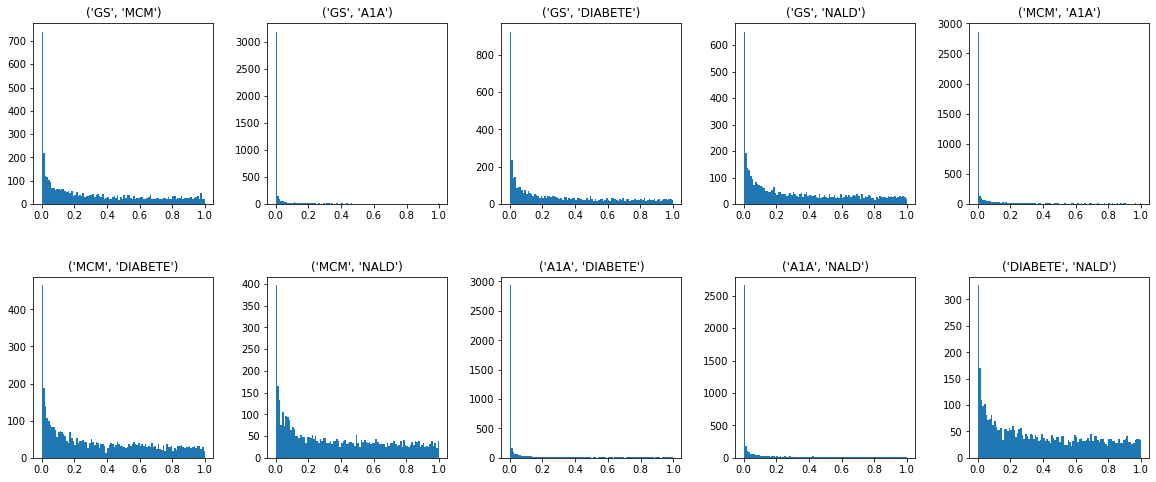

In [24]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.subplots_adjust(hspace = .4, wspace=.3)

i = 0
axs = axs.ravel()
for key, value in testing.items():
    axs[i].hist(testing[key], bins=100)
    axs[i].set_title(str(key))
    i += 1

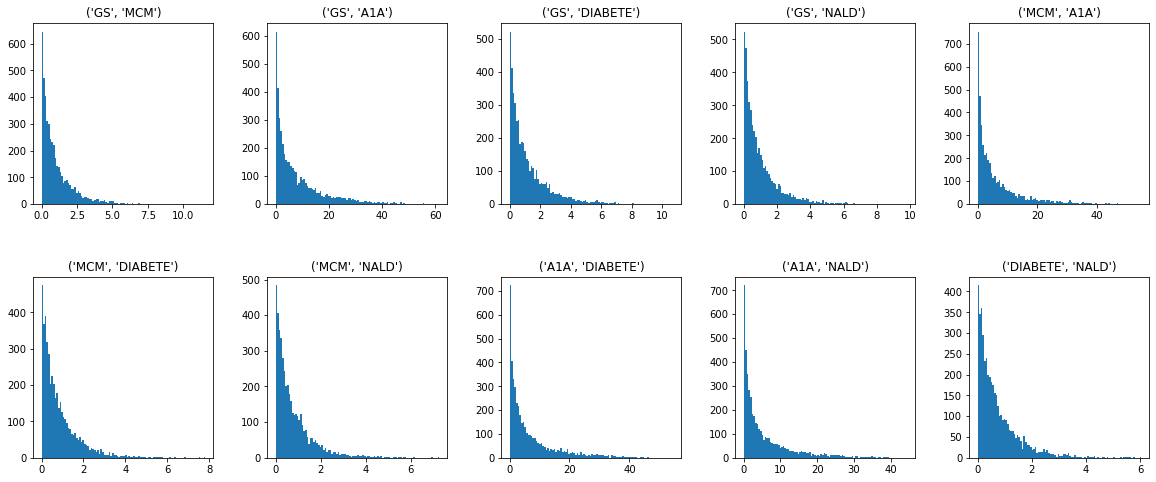

In [25]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.subplots_adjust(hspace = .4, wspace=.3)

f = lambda x: -math.log(x,10)
i = 0
axs = axs.ravel()
for key, value in testing.items():
    axs[i].hist([f(pval) for pval in value], bins=100)
    axs[i].set_title(str(key))
    i += 1

In [26]:
testing_l2fc = pairwise_hyp_testing(df, 'DISEASE', ['GS', 'MCM', 'A1A', 'DIABETE', 'NALD'], log2fc)

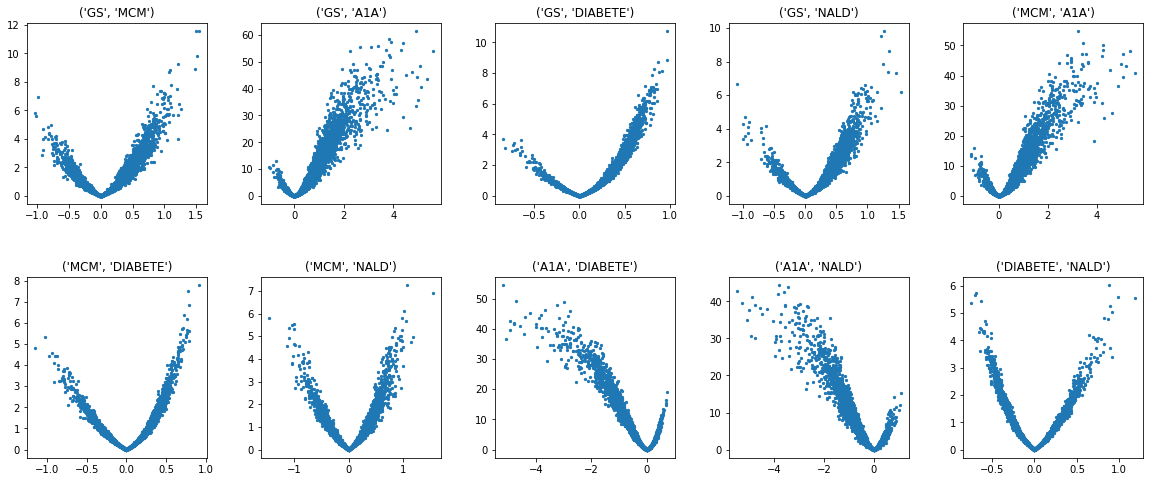

In [27]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.subplots_adjust(hspace = .4, wspace=.3)

f = lambda x: -math.log(x,10)
i = 0
axs = axs.ravel()
for key, value in testing.items():
    axs[i].scatter(testing_l2fc[key], [f(pval) for pval in value], s=5)
    axs[i].set_title(str(key))
    i += 1

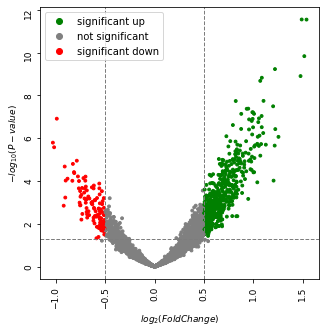

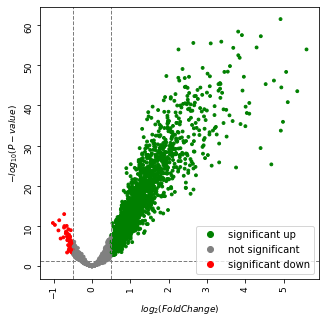

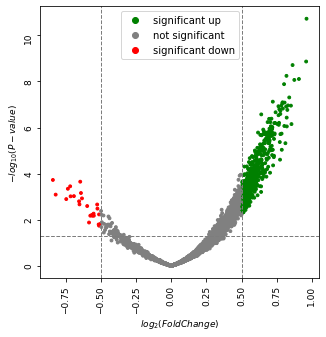

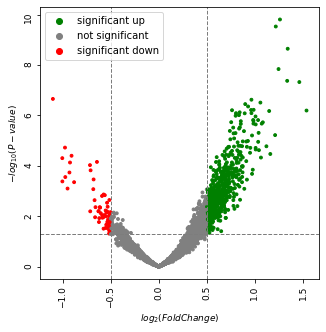

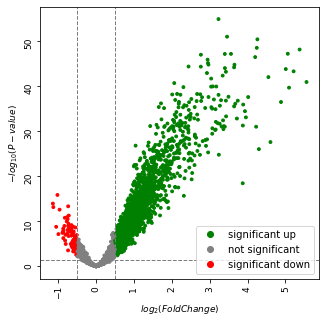

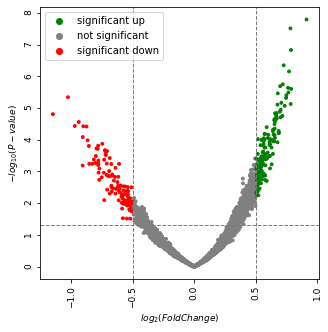

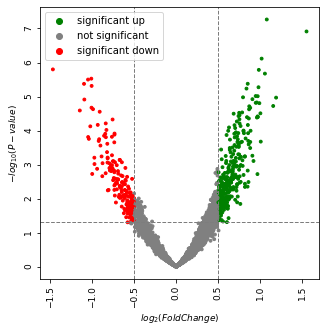

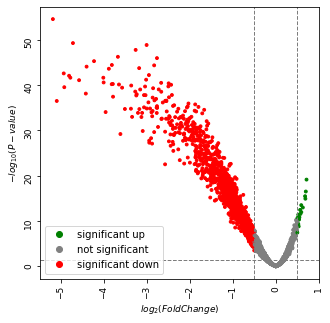

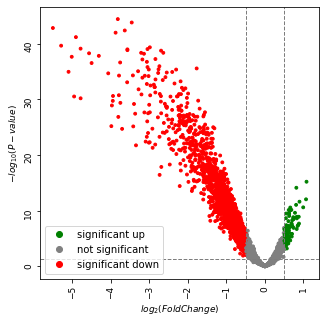

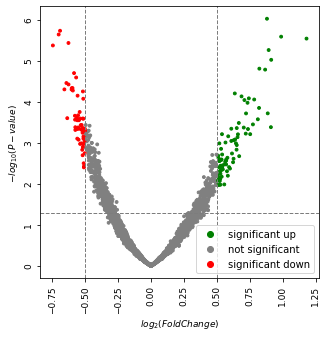

In [28]:
for key, value in testing.items():
    volcano = pd.DataFrame(data={'Genes': data_cols, 'log2FC': testing_l2fc[key], 'pvalue': value})
    visuz.GeneExpression.volcano(df=volcano, lfc='log2FC', pv='pvalue',
                             #geneid='Genes', genenames='deg',
                             # threshold pair (right, left) always positive
                             lfc_thr=(0.5, 0.5), pv_thr=(0.05, 0.05), 
                             figname=str(key), dim=(5,5), sign_line=True, plotlegend=True, show=True)

## pValue - 2LFC test

In [29]:
data_cols = [col_name for col_name in df.columns if col_name != 'DISEASE']
genes_dict = gene_selection(testing, data_cols, 0.005, '2fc', testing_l2fc, 0.5)

In [30]:
union = gene_union(genes_dict)

In [31]:
len(union)

3184

# T-test

In [32]:
testing = pairwise_hyp_testing(df, 'DISEASE', ['GS', 'MCM', 'A1A', 'DIABETE', 'NALD'], t_test)

In [33]:
data_cols = [col_name for col_name in df.columns if col_name != 'DISEASE']
genes_dict = gene_selection(testing, data_cols, 0.05, 'bonferroni')

In [34]:
union = gene_union(genes_dict)

In [35]:
len(union)

3960

# Wilcoxon test

In [36]:
testing = pairwise_hyp_testing(df, 'DISEASE', ['GS', 'MCM', 'A1A', 'DIABETE', 'NALD'], wilcoxon_test)

In [37]:
data_cols = [col_name for col_name in df.columns if col_name != 'DISEASE']
genes_dict = gene_selection(testing, data_cols, 0.05, 'bonferroni')

In [38]:
union = gene_union(genes_dict)

In [39]:
len(union)

3945

# KS test Union

In [ ]:
testing = pairwise_hyp_testing(df, 'DISEASE', ['GS', 'MCM', 'A1A', 'DIABETE', 'NALD'], ks_test)

In [ ]:
data_cols = [col_name for col_name in df.columns if col_name != 'DISEASE']
genes_dict = gene_selection(testing, data_cols, 0.05, 'bonferroni')

In [ ]:
union = gene_union(genes_dict)

In [ ]:
len(union)

## KS test Intersection

In [ ]:
intersection = gene_intersection(genes_dict)

In [ ]:
len(intersection)

## Extract dataset after statistical test

In [ ]:
df[union+['DISEASE']]

## Detach Union Train and Test datasets

In [ ]:
pipeline.train_set[union+['DISEASE']].to_csv(path_or_buf = '../../dataset/trainU.csv')

In [ ]:
pipeline.test_set[union+['DISEASE']].to_csv(path_or_buf = '../../dataset/testU.csv')

## Detach Intersection Train and Test datasets

In [ ]:
pipeline.train_set[intersection+['DISEASE']].to_csv(path_or_buf = '../../dataset/trainI.csv')

In [ ]:
pipeline.test_set[intersection+['DISEASE']].to_csv(path_or_buf = '../../dataset/testI.csv')